In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matosevic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [3]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [4]:
def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [5]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Synthetic data

In [9]:
test_syn_data = np.loadtxt('synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('synthetic-data/synthetic_train.txt', dtype=int)

In [10]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)
val_inputs, val_targets = get_batches_synthetic(test_syn_data, batch_size)

### Encoder-decoder

In [46]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [47]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden
    
    def greedy(self, hidden, first_word_index, last_word_index, max_sentence_length):
        first_word_index = torch.tensor(first_word_index, dtype=torch.long)
        next_word = self.embed(first_word_index)
        predicted = [next_word]
        while next_word != last_word_index and len(predicted) < max_sentence_length:
            output, hidden = self.lstm(next_word.float(), hidden) 
            softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
            next_word = np.random.choice(1, p=softmax_outputs)
            predicted.append(next_word)
        if predicted[-1] != last_word_index:
            predicted.append(last_word_index)
        return predicted

#         last_word = softmax_outputs[-1,:]

### VAE

In [48]:
# class Stochastic(nn.Module):
#     def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
#         super(Stochastic, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
# #         if synthetic:          
# #             for param in self.parameters():
# #                 nn.init.uniform_(param, -0.01, 0.01)

#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def forward(self, hidden_concatenated):
#         mean = self.hidden_to_mean(hidden_concatenated)
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden_concatenated = self.latent_to_hidden(z)
#         return hidden_concatenated, mean, log_variance

In [49]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [50]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [51]:
# # new VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
#         self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
#         self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
#         # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
#         ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
#         ## with this distribution it (kind of) works both without annealing and with annealing 
#         ## (why??? who knows)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
    
#     def latent_to_hidden(self, x):
#         return self.stochastic.latent_to_hidden(x)
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs
    
#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
#         hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [52]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
            nn.init.uniform_(self.encoder.embed.weight, -0.1, 0.1)
            nn.init.uniform_(self.decoder.embed.weight, -0.1, 0.1)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    # with teacher forcing
    def decode(self, hidden, x, x_lens=None, train=True): 
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def generate(self, z, first_word_index, last_word_index, max_sentence_length):
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        generated_sequence = self.decoder.greedy(hidden, first_word_index, last_word_index, max_sentence_length)
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs
    
    def calc_mi(self, x):
        """Approximate the mutual information between x and z
        I(x, z) = E_xE_{q(z|x)}log(q(z|x)) - E_xE_{q(z|x)}log(q(z))
        Returns: Float
        """
        mean, log_variance, _ = self.forward(x)
        _, batch_size, _ = mean.size()

        # E_{q(z|x)}log(q(z|x)) = -0.5*nz*log(2*\pi) - 0.5*(1+logvar).sum(-1)
        neg_entropy = (-0.5 * self.latent_dim * np.log(2 * np.pi)- 0.5 * (1 + log_variance).sum(-1)).mean()

        # [z_batch, 1, nz]
        z = self.stochastic_encoder.reparametrize(mean, log_variance)

        # [1, x_batch, nz]
        mean, log_variance = mean.unsqueeze(0), log_variance.unsqueeze(0)

        # (z_batch, x_batch, nz)

        # (z_batch, x_batch)
        log_density = -0.5 * (((z - mean) ** 2) / log_variance.exp()).sum(dim=-1) - \
            0.5 * (self.latent_dim * np.log(2 * np.pi) + log_variance.sum(-1))

        # log q(z): aggregate posterior
        # [z_batch]
        log_qz = log_sum_exp(log_density, dim=1) - np.log(batch_size)

        return (neg_entropy - log_qz.mean(-1)).item()

In [53]:
# # old VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [54]:
# def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
#     BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
#     KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
#     if annealing_args is not None:
#         kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
#     else:
#         kl_weight = 1.0
#     BCE = BCE / mean.shape[1]  # divide by batch size
#     KLD /= mean.shape[1]
#     weighted_KLD = kl_weight * KLD
#     loss = BCE + weighted_KLD
#     return loss, BCE, KLD, weighted_KLD, kl_weight
    
# def kl_annealing_weight(annealing_type, step, k, first_step):
#     if annealing_type == 'logistic':
#         return float(1/(1+np.exp(-k*(step-first_step))))
#     elif annealing_type == 'linear':
#         return min(1, step/first_step)

In [55]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='none')(outputs, labels).view(mean.shape[1], -1).sum(-1)
    KLD = -0.5 * (1 + log_variance - mean.pow(2) - log_variance.exp()).permute(1, 0, 2).squeeze(-1).squeeze(-1)
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

In [56]:
def generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode):
    interpolations = np.zeros((z1.shape[0], number_of_sentences_to_decode + 2))
    for dimension_of_z, (i, j) in enumerate(zip(z1, z2)):
        interpolations[dimension_of_z] = np.linspace(i, j, number_of_sentences_to_decode + 2)    
    return interpolations.T

### True posterior

In [59]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [60]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    vae.eval()
    approximate_mean, _, _ = vae.forward(tracked_inputs)
    vae.train()
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    if iteration is not None:
        plt.title("iteration {0}".format(iteration))
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [61]:
def train(vae, inputs, targets, validation_data, epochs, vocab_size, hidden_size, latent_size, input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          is_aggressive=False, plot=False, plot_lim=1.5, verbose=True):
    
    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
    
    previous_mi = -1
        
    for epoch in range(epochs):        
        for i in np.random.permutation(len(inputs)):
            
            inner_iter = 1
            random_i = i
            
            burn_num_words = 0
            burn_pre_loss = 1e4
            burn_cur_loss = 0
            while is_aggressive and inner_iter < 100:
                x = inputs[random_i]
                y = torch.tensor(targets[random_i].reshape(-1), dtype=torch.long)
                x_lens = input_lens[random_i] if not synthetic else None
                
                enc_optimizer.zero_grad()
                stoch_enc_optimizer.zero_grad()
                stoch_dec_optimizer.zero_grad()
                dec_optimizer.zero_grad()
                
                burn_batch_size, burn_sents_len, _ = x.shape
                burn_num_words += burn_sents_len * burn_batch_size
              
                mean, log_variance, outputs = vae(x, x_lens=x_lens)
                if not synthetic:
                    mask = (y < padding_index)
                    outputs = outputs[mask]
                    y = y[mask]
    
                loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
                
                loss = loss_summary[0]
                burn_cur_loss += loss.sum().item()
                
                loss = loss.mean(dim=-1)
                loss.backward()
                
                clip_grad_norm_(vae.parameters(), 5.0)
                
                stoch_enc_optimizer.step()
                enc_optimizer.step()
                random_i = np.random.randint(0, len(inputs)- 1)
                if inner_iter % 15 == 0:
                    burn_cur_loss = burn_cur_loss / burn_num_words
                    if burn_pre_loss - burn_cur_loss < 0:
                        break
                    burn_pre_loss = burn_cur_loss
                    burn_cur_loss = burn_num_words = 0
                inner_iter += 1
              
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None  
            
            mean, log_variance, outputs = vae(x, x_lens=x_lens)
            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]

            loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
            total_losses.append(np.mean(loss_summary[0].data.numpy()))
            ce_losses.append(np.mean(loss_summary[1].data.numpy()))
            kl_losses.append(np.mean(loss_summary[3].data.numpy()))
            
            loss = loss_summary[0]
                
            loss = loss.mean(dim=-1)
            
            if annealing_args is not None:
                kl_terms.append(np.mean(loss_summary[2].data.numpy()))
                kl_weights.append(loss_summary[4])     
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
#             vae_optimizer.zero_grad()
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            dec_optimizer.step()
            stoch_dec_optimizer.step()
            if not is_aggressive:
                stoch_enc_optimizer.step()
                enc_optimizer.step()
            #vae_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss, loss_summary[1].mean(dim=-1).data.item(), \
                            loss_summary[2].mean(dim=-1).data.item(), \
                            loss_summary[3].mean(dim=-1).data.item(), loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration
        
        if is_aggressive:
            vae.eval()
            current_mi = calc_mi(vae, validation_data)
            vae.train()
            print('current_mi:', current_mi)
            if current_mi - previous_mi < 0:
                is_aggressive = False
                print("STOP AGGRESSIVE")

            previous_mi = current_mi
                
        if (epoch % 1 == 0) and plot:
            plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
       
    
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}\n'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))
    
    if annealing_args is not None:
        plot_kl(kl_terms, kl_weights)
    plot_losses(total_losses, ce_losses, kl_losses)
    
def calc_mi(model, test_data_batch):
    mi = 0
    num_examples = 0
    for batch_data in test_data_batch:
        batch_size = batch_data.shape[0]
        num_examples += batch_size
        mutual_info = model.calc_mi(batch_data)
        mi += mutual_info * batch_size

    return mi / num_examples

### Synthetic data

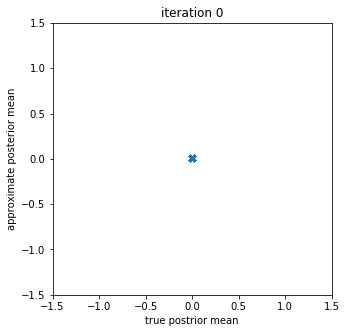

epoch 1 iteration 0 loss 62.176 CE 62.176 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 48.690 CE 48.690 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 200 loss 41.455 CE 41.455 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 300 loss 39.895 CE 39.891 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 400 loss 37.767 CE 37.765 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 500 loss 39.062 CE 39.058 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 600 loss 37.637 CE 37.637 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 700 loss 38.115 CE 38.115 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 800 loss 37.216 CE 37.213 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 900 loss 36.917 CE 36.913 KL 0.005 weighted KL: 0.005 weight 1.000


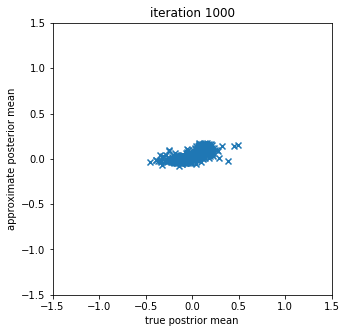

Epoch [1/10], Loss: 35.9462, Perplexity: 4085265755327241.50

epoch 2 iteration 1000 loss 40.718 CE 40.715 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 2 iteration 1100 loss 34.810 CE 34.800 KL 0.010 weighted KL: 0.010 weight 1.000
epoch 2 iteration 1200 loss 32.627 CE 32.619 KL 0.008 weighted KL: 0.008 weight 1.000
epoch 2 iteration 1300 loss 34.406 CE 34.397 KL 0.009 weighted KL: 0.009 weight 1.000
epoch 2 iteration 1400 loss 30.560 CE 30.534 KL 0.026 weighted KL: 0.026 weight 1.000
epoch 2 iteration 1500 loss 36.442 CE 36.417 KL 0.025 weighted KL: 0.025 weight 1.000
epoch 2 iteration 1600 loss 32.824 CE 32.816 KL 0.008 weighted KL: 0.008 weight 1.000
epoch 2 iteration 1700 loss 29.001 CE 28.997 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 2 iteration 1800 loss 30.587 CE 30.568 KL 0.018 weighted KL: 0.018 weight 1.000
epoch 2 iteration 1900 loss 31.318 CE 31.315 KL 0.003 weighted KL: 0.003 weight 1.000


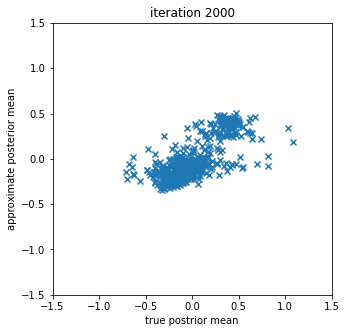

Epoch [2/10], Loss: 32.5299, Perplexity: 134140790711972.75

epoch 3 iteration 2000 loss 33.115 CE 33.084 KL 0.031 weighted KL: 0.031 weight 1.000
epoch 3 iteration 2100 loss 31.255 CE 31.246 KL 0.009 weighted KL: 0.009 weight 1.000
epoch 3 iteration 2200 loss 29.212 CE 29.205 KL 0.006 weighted KL: 0.006 weight 1.000
epoch 3 iteration 2300 loss 32.377 CE 32.375 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 3 iteration 2400 loss 29.543 CE 29.542 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 3 iteration 2500 loss 31.804 CE 31.800 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 3 iteration 2600 loss 32.824 CE 32.819 KL 0.006 weighted KL: 0.006 weight 1.000
epoch 3 iteration 2700 loss 30.524 CE 30.521 KL 0.003 weighted KL: 0.003 weight 1.000
epoch 3 iteration 2800 loss 34.782 CE 34.771 KL 0.010 weighted KL: 0.010 weight 1.000
epoch 3 iteration 2900 loss 29.718 CE 29.717 KL 0.001 weighted KL: 0.001 weight 1.000


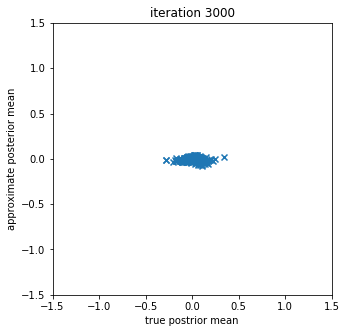

Epoch [3/10], Loss: 30.6016, Perplexity: 19503144643685.56

epoch 4 iteration 3000 loss 30.215 CE 30.215 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3100 loss 31.316 CE 31.315 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3200 loss 30.971 CE 30.969 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 4 iteration 3300 loss 32.709 CE 32.708 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3400 loss 32.402 CE 32.400 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3500 loss 35.813 CE 35.812 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3600 loss 33.974 CE 33.973 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3700 loss 32.621 CE 32.621 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3800 loss 31.819 CE 31.819 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3900 loss 28.864 CE 28.864 KL 0.000 weighted KL: 0.000 weight 1.000


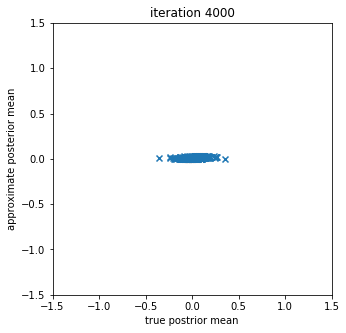

Epoch [4/10], Loss: 31.0762, Perplexity: 31348905973749.80

epoch 5 iteration 4000 loss 30.827 CE 30.827 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4100 loss 26.829 CE 26.824 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 5 iteration 4200 loss 30.990 CE 30.985 KL 0.005 weighted KL: 0.005 weight 1.000
epoch 5 iteration 4300 loss 28.509 CE 28.508 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 5 iteration 4400 loss 29.425 CE 29.423 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 5 iteration 4500 loss 28.225 CE 28.223 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 5 iteration 4600 loss 31.291 CE 31.291 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4700 loss 29.365 CE 29.363 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 5 iteration 4800 loss 30.147 CE 30.147 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4900 loss 33.222 CE 33.221 KL 0.000 weighted KL: 0.000 weight 1.000


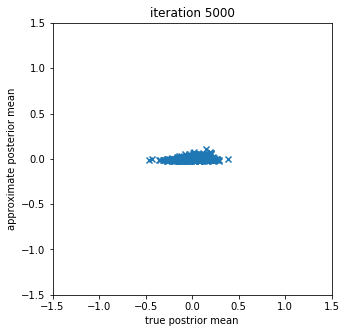

Epoch [5/10], Loss: 24.9875, Perplexity: 71110792757.52

epoch 6 iteration 5000 loss 35.191 CE 35.190 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5100 loss 29.260 CE 29.259 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 6 iteration 5200 loss 27.713 CE 27.712 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5300 loss 29.804 CE 29.804 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5400 loss 33.705 CE 33.703 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 6 iteration 5500 loss 36.322 CE 36.322 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5600 loss 24.573 CE 24.571 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 6 iteration 5700 loss 30.564 CE 30.563 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5800 loss 25.193 CE 25.193 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5900 loss 32.701 CE 32.700 KL 0.000 weighted KL: 0.000 weight 1.000


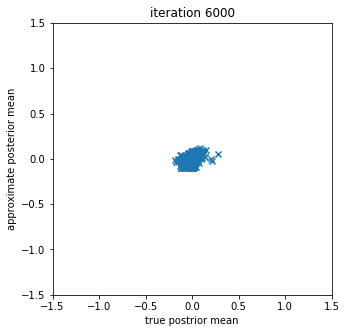

Epoch [6/10], Loss: 28.1917, Perplexity: 1751941571097.86

epoch 7 iteration 6000 loss 31.895 CE 31.894 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 7 iteration 6100 loss 28.823 CE 28.823 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 7 iteration 6200 loss 31.745 CE 31.743 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 7 iteration 6300 loss 29.866 CE 29.866 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6400 loss 31.465 CE 31.465 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6500 loss 33.372 CE 33.372 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6600 loss 29.589 CE 29.588 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6700 loss 32.410 CE 32.410 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6800 loss 30.747 CE 30.747 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6900 loss 28.456 CE 28.454 KL 0.002 weighted KL: 0.002 weight 1.000


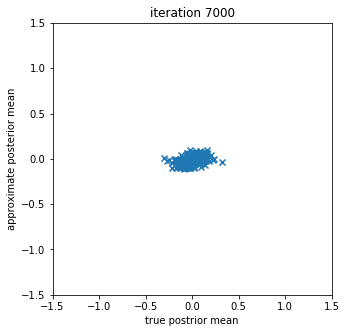

Epoch [7/10], Loss: 30.0938, Perplexity: 11737020098923.06

epoch 8 iteration 7000 loss 32.017 CE 32.017 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7100 loss 32.761 CE 32.761 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7200 loss 33.388 CE 33.388 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7300 loss 29.686 CE 29.686 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7400 loss 31.635 CE 31.635 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7500 loss 31.909 CE 31.909 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7600 loss 33.632 CE 33.632 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7700 loss 31.614 CE 31.614 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7800 loss 29.523 CE 29.523 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7900 loss 25.946 CE 25.946 KL 0.000 weighted KL: 0.000 weight 1.000


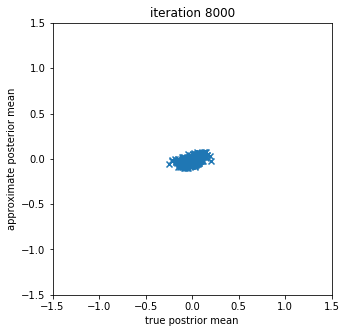

Epoch [8/10], Loss: 28.8409, Perplexity: 3353003183830.41

epoch 9 iteration 8000 loss 30.623 CE 30.622 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 9 iteration 8100 loss 32.054 CE 32.054 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8200 loss 28.041 CE 28.039 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 9 iteration 8300 loss 33.977 CE 33.976 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 9 iteration 8400 loss 31.848 CE 31.848 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8500 loss 27.076 CE 27.076 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8600 loss 29.113 CE 29.113 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8700 loss 29.687 CE 29.687 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 9 iteration 8800 loss 30.357 CE 30.355 KL 0.002 weighted KL: 0.002 weight 1.000
epoch 9 iteration 8900 loss 27.573 CE 27.573 KL 0.000 weighted KL: 0.000 weight 1.000


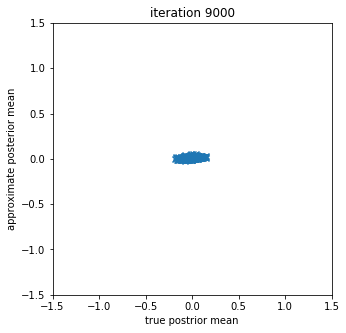

Epoch [9/10], Loss: 27.6086, Perplexity: 977782346614.27

epoch 10 iteration 9000 loss 26.447 CE 26.446 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9100 loss 29.547 CE 29.547 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9200 loss 30.481 CE 30.480 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 10 iteration 9300 loss 26.876 CE 26.876 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9400 loss 26.291 CE 26.290 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9500 loss 32.591 CE 32.590 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9600 loss 30.833 CE 30.833 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9700 loss 27.482 CE 27.481 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9800 loss 27.920 CE 27.920 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9900 loss 27.260 CE 27.260 KL 0.000 weighted KL: 0.000 weight 1.000


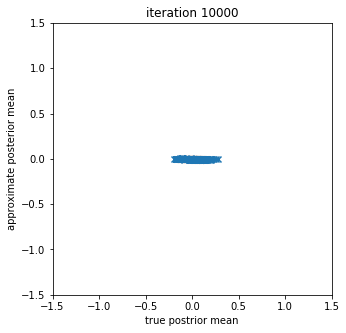

Epoch [10/10], Loss: 27.0091, Perplexity: 536930388448.36



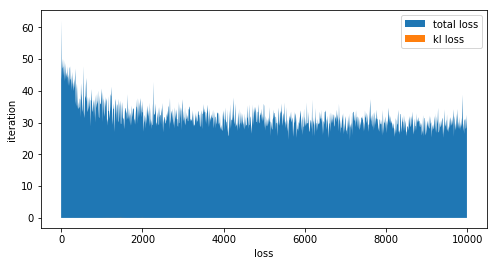

In [40]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5)

In [0]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

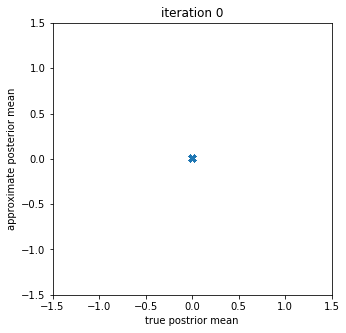

epoch 1 iteration 0 loss 62.161 CE 62.161 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 48.730 CE 48.729 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 1 iteration 200 loss 41.208 CE 41.204 KL 0.004 weighted KL: 0.004 weight 1.000
epoch 1 iteration 300 loss 38.875 CE 38.022 KL 0.853 weighted KL: 0.853 weight 1.000
epoch 1 iteration 400 loss 37.164 CE 35.805 KL 1.359 weighted KL: 1.359 weight 1.000
epoch 1 iteration 500 loss 37.434 CE 35.925 KL 1.509 weighted KL: 1.509 weight 1.000
epoch 1 iteration 600 loss 36.904 CE 35.358 KL 1.546 weighted KL: 1.546 weight 1.000
epoch 1 iteration 700 loss 38.665 CE 36.965 KL 1.701 weighted KL: 1.701 weight 1.000
epoch 1 iteration 800 loss 38.007 CE 36.288 KL 1.719 weighted KL: 1.719 weight 1.000
epoch 1 iteration 900 loss 34.559 CE 32.849 KL 1.710 weighted KL: 1.710 weight 1.000
current_mi: 2.770010947227478


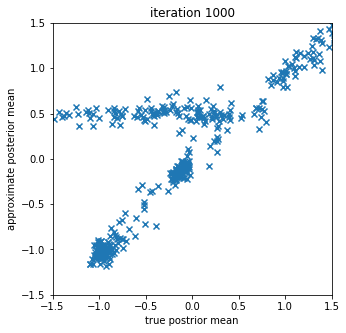

Epoch [1/10], Loss: 35.7895, Perplexity: 3492700447526533.00

epoch 2 iteration 1000 loss 32.365 CE 30.658 KL 1.707 weighted KL: 1.707 weight 1.000
epoch 2 iteration 1100 loss 34.463 CE 32.928 KL 1.535 weighted KL: 1.535 weight 1.000
epoch 2 iteration 1200 loss 32.093 CE 30.563 KL 1.530 weighted KL: 1.530 weight 1.000
epoch 2 iteration 1300 loss 30.762 CE 29.036 KL 1.726 weighted KL: 1.726 weight 1.000
epoch 2 iteration 1400 loss 32.095 CE 30.366 KL 1.729 weighted KL: 1.729 weight 1.000
epoch 2 iteration 1500 loss 34.172 CE 32.491 KL 1.680 weighted KL: 1.680 weight 1.000
epoch 2 iteration 1600 loss 29.489 CE 27.797 KL 1.692 weighted KL: 1.692 weight 1.000
epoch 2 iteration 1700 loss 32.768 CE 30.915 KL 1.853 weighted KL: 1.853 weight 1.000
epoch 2 iteration 1800 loss 33.258 CE 31.327 KL 1.931 weighted KL: 1.931 weight 1.000
epoch 2 iteration 1900 loss 33.528 CE 31.780 KL 1.748 weighted KL: 1.748 weight 1.000
current_mi: 2.7714265747070312


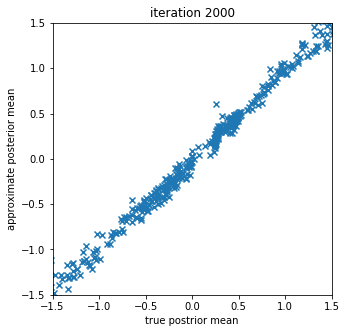

Epoch [2/10], Loss: 33.7675, Perplexity: 462421540513602.19

epoch 3 iteration 2000 loss 29.778 CE 27.974 KL 1.803 weighted KL: 1.803 weight 1.000
epoch 3 iteration 2100 loss 31.642 CE 29.710 KL 1.932 weighted KL: 1.932 weight 1.000
epoch 3 iteration 2200 loss 33.202 CE 31.425 KL 1.777 weighted KL: 1.777 weight 1.000
epoch 3 iteration 2300 loss 30.883 CE 28.864 KL 2.019 weighted KL: 2.019 weight 1.000
epoch 3 iteration 2400 loss 34.652 CE 32.641 KL 2.011 weighted KL: 2.011 weight 1.000
epoch 3 iteration 2500 loss 32.570 CE 30.664 KL 1.906 weighted KL: 1.906 weight 1.000
epoch 3 iteration 2600 loss 28.564 CE 26.705 KL 1.859 weighted KL: 1.859 weight 1.000
epoch 3 iteration 2700 loss 34.097 CE 31.955 KL 2.142 weighted KL: 2.142 weight 1.000
epoch 3 iteration 2800 loss 32.288 CE 30.266 KL 2.022 weighted KL: 2.022 weight 1.000
epoch 3 iteration 2900 loss 32.439 CE 30.502 KL 1.937 weighted KL: 1.937 weight 1.000
current_mi: 2.7824548711776735


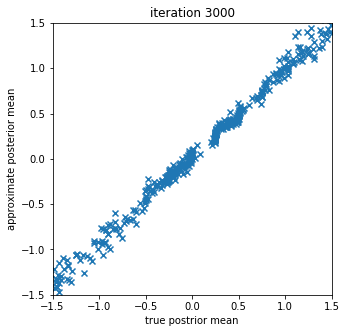

Epoch [3/10], Loss: 32.8150, Perplexity: 178384148733530.94

epoch 4 iteration 3000 loss 32.264 CE 30.227 KL 2.037 weighted KL: 2.037 weight 1.000
epoch 4 iteration 3100 loss 36.599 CE 34.496 KL 2.103 weighted KL: 2.103 weight 1.000
epoch 4 iteration 3200 loss 32.682 CE 30.740 KL 1.942 weighted KL: 1.942 weight 1.000
epoch 4 iteration 3300 loss 32.823 CE 30.890 KL 1.933 weighted KL: 1.933 weight 1.000
epoch 4 iteration 3400 loss 31.813 CE 29.884 KL 1.929 weighted KL: 1.929 weight 1.000
epoch 4 iteration 3500 loss 29.706 CE 27.759 KL 1.947 weighted KL: 1.947 weight 1.000
epoch 4 iteration 3600 loss 33.920 CE 32.067 KL 1.852 weighted KL: 1.852 weight 1.000
epoch 4 iteration 3700 loss 30.662 CE 28.608 KL 2.054 weighted KL: 2.054 weight 1.000
epoch 4 iteration 3800 loss 33.664 CE 31.711 KL 1.952 weighted KL: 1.952 weight 1.000
epoch 4 iteration 3900 loss 33.726 CE 31.686 KL 2.040 weighted KL: 2.040 weight 1.000
current_mi: 2.773627395629883
STOP AGGRESSIVE


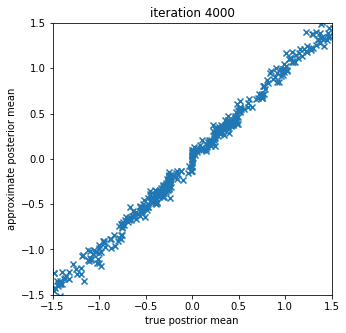

Epoch [4/10], Loss: 30.6756, Perplexity: 21001667180816.49

epoch 5 iteration 4000 loss 34.718 CE 32.761 KL 1.957 weighted KL: 1.957 weight 1.000
epoch 5 iteration 4100 loss 33.028 CE 31.040 KL 1.989 weighted KL: 1.989 weight 1.000
epoch 5 iteration 4200 loss 29.811 CE 27.924 KL 1.887 weighted KL: 1.887 weight 1.000
epoch 5 iteration 4300 loss 32.539 CE 30.724 KL 1.816 weighted KL: 1.816 weight 1.000
epoch 5 iteration 4400 loss 30.475 CE 28.569 KL 1.906 weighted KL: 1.906 weight 1.000
epoch 5 iteration 4500 loss 32.454 CE 30.592 KL 1.863 weighted KL: 1.863 weight 1.000
epoch 5 iteration 4600 loss 33.449 CE 31.467 KL 1.982 weighted KL: 1.982 weight 1.000
epoch 5 iteration 4700 loss 28.078 CE 25.999 KL 2.080 weighted KL: 2.080 weight 1.000
epoch 5 iteration 4800 loss 32.456 CE 30.456 KL 2.000 weighted KL: 2.000 weight 1.000
epoch 5 iteration 4900 loss 30.158 CE 28.195 KL 1.963 weighted KL: 1.963 weight 1.000


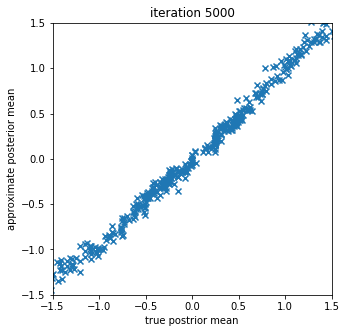

Epoch [5/10], Loss: 38.8127, Perplexity: 71801596455127160.00

epoch 6 iteration 5000 loss 29.869 CE 28.026 KL 1.843 weighted KL: 1.843 weight 1.000
epoch 6 iteration 5100 loss 34.265 CE 32.405 KL 1.860 weighted KL: 1.860 weight 1.000
epoch 6 iteration 5200 loss 29.079 CE 27.029 KL 2.050 weighted KL: 2.050 weight 1.000
epoch 6 iteration 5300 loss 31.171 CE 29.195 KL 1.975 weighted KL: 1.975 weight 1.000
epoch 6 iteration 5400 loss 33.241 CE 31.396 KL 1.845 weighted KL: 1.845 weight 1.000
epoch 6 iteration 5500 loss 25.866 CE 23.965 KL 1.902 weighted KL: 1.902 weight 1.000
epoch 6 iteration 5600 loss 29.495 CE 27.625 KL 1.870 weighted KL: 1.870 weight 1.000
epoch 6 iteration 5700 loss 29.358 CE 27.464 KL 1.894 weighted KL: 1.894 weight 1.000
epoch 6 iteration 5800 loss 33.335 CE 31.411 KL 1.924 weighted KL: 1.924 weight 1.000
epoch 6 iteration 5900 loss 33.043 CE 31.085 KL 1.958 weighted KL: 1.958 weight 1.000


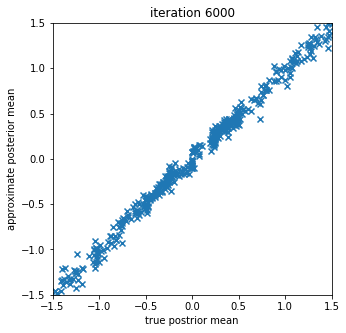

Epoch [6/10], Loss: 32.8240, Perplexity: 179999395661137.97

epoch 7 iteration 6000 loss 30.322 CE 28.495 KL 1.827 weighted KL: 1.827 weight 1.000
epoch 7 iteration 6100 loss 30.648 CE 28.795 KL 1.853 weighted KL: 1.853 weight 1.000
epoch 7 iteration 6200 loss 29.592 CE 27.632 KL 1.960 weighted KL: 1.960 weight 1.000
epoch 7 iteration 6300 loss 30.687 CE 28.869 KL 1.819 weighted KL: 1.819 weight 1.000
epoch 7 iteration 6400 loss 29.303 CE 27.415 KL 1.887 weighted KL: 1.887 weight 1.000
epoch 7 iteration 6500 loss 28.200 CE 26.339 KL 1.861 weighted KL: 1.861 weight 1.000
epoch 7 iteration 6600 loss 31.422 CE 29.531 KL 1.891 weighted KL: 1.891 weight 1.000
epoch 7 iteration 6700 loss 32.902 CE 30.915 KL 1.986 weighted KL: 1.986 weight 1.000
epoch 7 iteration 6800 loss 28.303 CE 26.501 KL 1.802 weighted KL: 1.802 weight 1.000
epoch 7 iteration 6900 loss 32.809 CE 30.858 KL 1.951 weighted KL: 1.951 weight 1.000


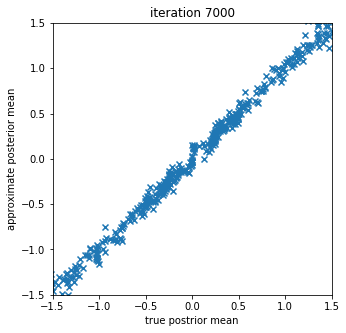

Epoch [7/10], Loss: 31.8061, Perplexity: 65043412649651.19

epoch 8 iteration 7000 loss 26.052 CE 24.216 KL 1.836 weighted KL: 1.836 weight 1.000
epoch 8 iteration 7100 loss 28.512 CE 26.583 KL 1.929 weighted KL: 1.929 weight 1.000
epoch 8 iteration 7200 loss 31.173 CE 29.318 KL 1.855 weighted KL: 1.855 weight 1.000
epoch 8 iteration 7300 loss 28.243 CE 26.365 KL 1.879 weighted KL: 1.879 weight 1.000
epoch 8 iteration 7400 loss 31.523 CE 29.650 KL 1.873 weighted KL: 1.873 weight 1.000
epoch 8 iteration 7500 loss 30.974 CE 29.050 KL 1.923 weighted KL: 1.923 weight 1.000
epoch 8 iteration 7600 loss 33.109 CE 31.188 KL 1.921 weighted KL: 1.921 weight 1.000
epoch 8 iteration 7700 loss 29.516 CE 27.672 KL 1.843 weighted KL: 1.843 weight 1.000
epoch 8 iteration 7800 loss 32.107 CE 30.197 KL 1.909 weighted KL: 1.909 weight 1.000
epoch 8 iteration 7900 loss 29.514 CE 27.732 KL 1.782 weighted KL: 1.782 weight 1.000


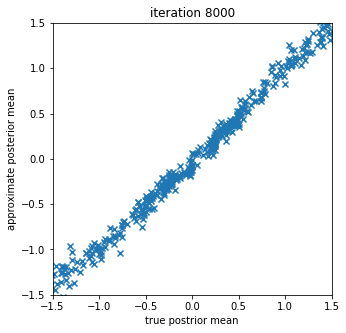

Epoch [8/10], Loss: 31.9760, Perplexity: 77090543725568.70

epoch 9 iteration 8000 loss 31.123 CE 29.169 KL 1.954 weighted KL: 1.954 weight 1.000
epoch 9 iteration 8100 loss 32.437 CE 30.549 KL 1.889 weighted KL: 1.889 weight 1.000
epoch 9 iteration 8200 loss 30.343 CE 28.498 KL 1.845 weighted KL: 1.845 weight 1.000
epoch 9 iteration 8300 loss 30.567 CE 28.680 KL 1.887 weighted KL: 1.887 weight 1.000
epoch 9 iteration 8400 loss 27.559 CE 25.596 KL 1.963 weighted KL: 1.963 weight 1.000
epoch 9 iteration 8500 loss 27.873 CE 26.107 KL 1.767 weighted KL: 1.767 weight 1.000
epoch 9 iteration 8600 loss 33.459 CE 31.551 KL 1.908 weighted KL: 1.908 weight 1.000
epoch 9 iteration 8700 loss 29.763 CE 27.870 KL 1.892 weighted KL: 1.892 weight 1.000
epoch 9 iteration 8800 loss 33.231 CE 31.377 KL 1.854 weighted KL: 1.854 weight 1.000
epoch 9 iteration 8900 loss 25.823 CE 23.959 KL 1.864 weighted KL: 1.864 weight 1.000


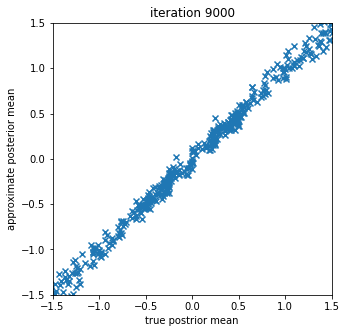

Epoch [9/10], Loss: 34.2667, Perplexity: 761828595709661.88

epoch 10 iteration 9000 loss 27.886 CE 25.984 KL 1.902 weighted KL: 1.902 weight 1.000
epoch 10 iteration 9100 loss 29.071 CE 27.161 KL 1.910 weighted KL: 1.910 weight 1.000
epoch 10 iteration 9200 loss 31.913 CE 29.949 KL 1.964 weighted KL: 1.964 weight 1.000
epoch 10 iteration 9300 loss 27.871 CE 26.057 KL 1.815 weighted KL: 1.815 weight 1.000
epoch 10 iteration 9400 loss 29.895 CE 27.970 KL 1.925 weighted KL: 1.925 weight 1.000
epoch 10 iteration 9500 loss 30.242 CE 28.527 KL 1.715 weighted KL: 1.715 weight 1.000
epoch 10 iteration 9600 loss 27.760 CE 25.762 KL 1.998 weighted KL: 1.998 weight 1.000
epoch 10 iteration 9700 loss 29.313 CE 27.489 KL 1.824 weighted KL: 1.824 weight 1.000
epoch 10 iteration 9800 loss 32.548 CE 30.729 KL 1.819 weighted KL: 1.819 weight 1.000
epoch 10 iteration 9900 loss 30.371 CE 28.521 KL 1.850 weighted KL: 1.850 weight 1.000


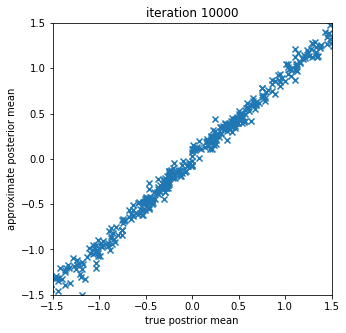

Epoch [10/10], Loss: 32.5355, Perplexity: 134892024801303.69



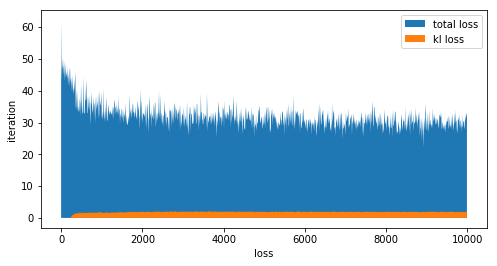

In [30]:
# aggresive training
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5, is_aggressive=True)

### Interpolate

# TEXT DATA

### Load Penn Treebank data

In [67]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

In [68]:
embedding_size = 500
epochs_w2v = 10

# word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
# word2vec_model.train(train_data, epochs=epochs_w2v, total_examples=word2vec_model.corpus_count)

word2vec_model = Word2Vec.load("word2vec.model")
# print(word2vec_model.wv.most_similar("stocks"))
# word2vec_model.wv['credit']

# vocabulary_size = len(word2vec_model.wv.vocab)
# print("size of the vocabulary:", vocabulary_size)
# word2vec_model.save("word2vec.model")

In [69]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [70]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

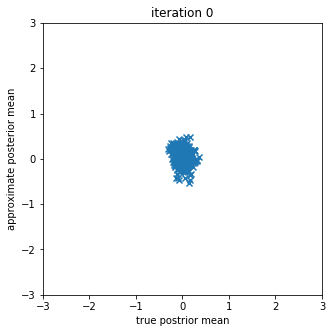

epoch 1 iteration 0 loss 83.065 CE 83.065 KL 0.015 weighted KL: 0.000 weight 0.002
epoch 1 iteration 100 loss 36.012 CE 35.974 KL 15.389 weighted KL: 0.038 weight 0.002
epoch 1 iteration 200 loss 36.411 CE 36.371 KL 12.648 weighted KL: 0.040 weight 0.003
epoch 1 iteration 300 loss 34.323 CE 34.216 KL 26.169 weighted KL: 0.107 weight 0.004
epoch 1 iteration 400 loss 31.691 CE 31.602 KL 17.094 weighted KL: 0.089 weight 0.005
epoch 1 iteration 500 loss 35.811 CE 35.717 KL 14.107 weighted KL: 0.094 weight 0.007
epoch 1 iteration 600 loss 29.039 CE 28.864 KL 20.403 weighted KL: 0.175 weight 0.009
epoch 1 iteration 700 loss 28.960 CE 28.733 KL 20.719 weighted KL: 0.228 weight 0.011
epoch 1 iteration 800 loss 31.333 CE 31.209 KL 8.860 weighted KL: 0.125 weight 0.014
epoch 1 iteration 900 loss 32.985 CE 32.833 KL 8.441 weighted KL: 0.152 weight 0.018


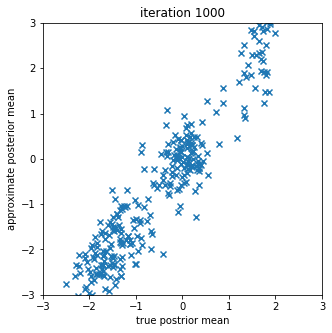

Epoch [1/10], Loss: 35.7938, Perplexity: 3507922419976022.00

epoch 2 iteration 1000 loss 34.009 CE 33.895 KL 4.945 weighted KL: 0.114 weight 0.023
epoch 2 iteration 1100 loss 32.637 CE 32.498 KL 4.745 weighted KL: 0.139 weight 0.029
epoch 2 iteration 1200 loss 29.324 CE 29.096 KL 6.108 weighted KL: 0.228 weight 0.037
epoch 2 iteration 1300 loss 28.969 CE 28.663 KL 6.452 weighted KL: 0.306 weight 0.047
epoch 2 iteration 1400 loss 35.517 CE 35.291 KL 3.768 weighted KL: 0.226 weight 0.060
epoch 2 iteration 1500 loss 31.808 CE 31.360 KL 5.902 weighted KL: 0.448 weight 0.076
epoch 2 iteration 1600 loss 34.407 CE 34.089 KL 3.334 weighted KL: 0.318 weight 0.095
epoch 2 iteration 1700 loss 33.091 CE 32.769 KL 2.696 weighted KL: 0.321 weight 0.119
epoch 2 iteration 1800 loss 28.847 CE 28.373 KL 3.202 weighted KL: 0.474 weight 0.148
epoch 2 iteration 1900 loss 26.817 CE 26.198 KL 3.390 weighted KL: 0.618 weight 0.182


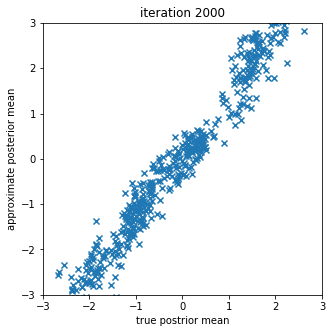

Epoch [2/10], Loss: 32.1364, Perplexity: 90505237058314.56

epoch 3 iteration 2000 loss 31.813 CE 31.228 KL 2.628 weighted KL: 0.585 weight 0.223
epoch 3 iteration 2100 loss 33.676 CE 33.098 KL 2.148 weighted KL: 0.578 weight 0.269
epoch 3 iteration 2200 loss 33.363 CE 32.647 KL 2.233 weighted KL: 0.716 weight 0.321
epoch 3 iteration 2300 loss 29.131 CE 28.207 KL 2.449 weighted KL: 0.925 weight 0.378
epoch 3 iteration 2400 loss 35.429 CE 34.745 KL 1.563 weighted KL: 0.684 weight 0.438
epoch 3 iteration 2500 loss 32.269 CE 31.375 KL 1.788 weighted KL: 0.894 weight 0.500
epoch 3 iteration 2600 loss 30.137 CE 29.075 KL 1.890 weighted KL: 1.063 weight 0.562
epoch 3 iteration 2700 loss 32.052 CE 31.099 KL 1.532 weighted KL: 0.953 weight 0.622
epoch 3 iteration 2800 loss 30.170 CE 29.125 KL 1.539 weighted KL: 1.045 weight 0.679
epoch 3 iteration 2900 loss 29.882 CE 28.774 KL 1.516 weighted KL: 1.108 weight 0.731


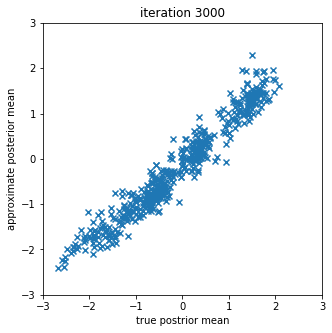

Epoch [3/10], Loss: 31.2902, Perplexity: 38830010829769.84

epoch 4 iteration 3000 loss 28.383 CE 27.340 KL 1.341 weighted KL: 1.043 weight 0.777
epoch 4 iteration 3100 loss 33.896 CE 32.979 KL 1.122 weighted KL: 0.917 weight 0.818
epoch 4 iteration 3200 loss 26.662 CE 25.443 KL 1.430 weighted KL: 1.218 weight 0.852
epoch 4 iteration 3300 loss 31.040 CE 29.720 KL 1.498 weighted KL: 1.320 weight 0.881
epoch 4 iteration 3400 loss 34.082 CE 33.213 KL 0.961 weighted KL: 0.869 weight 0.905
epoch 4 iteration 3500 loss 34.996 CE 33.823 KL 1.270 weighted KL: 1.173 weight 0.924
epoch 4 iteration 3600 loss 32.601 CE 31.470 KL 1.203 weighted KL: 1.131 weight 0.940
epoch 4 iteration 3700 loss 37.284 CE 36.327 KL 1.004 weighted KL: 0.957 weight 0.953
epoch 4 iteration 3800 loss 30.247 CE 28.915 KL 1.384 weighted KL: 1.332 weight 0.963
epoch 4 iteration 3900 loss 30.518 CE 29.205 KL 1.352 weighted KL: 1.312 weight 0.971


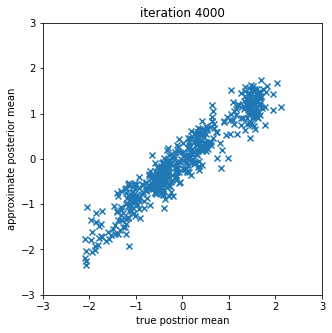

Epoch [4/10], Loss: 29.1268, Perplexity: 4462847657774.79

epoch 5 iteration 4000 loss 32.449 CE 31.505 KL 0.966 weighted KL: 0.944 weight 0.977
epoch 5 iteration 4100 loss 32.133 CE 31.149 KL 1.002 weighted KL: 0.984 weight 0.982
epoch 5 iteration 4200 loss 35.412 CE 34.648 KL 0.774 weighted KL: 0.763 weight 0.986
epoch 5 iteration 4300 loss 33.468 CE 32.538 KL 0.941 weighted KL: 0.930 weight 0.989
epoch 5 iteration 4400 loss 34.361 CE 33.412 KL 0.957 weighted KL: 0.949 weight 0.991
epoch 5 iteration 4500 loss 30.804 CE 29.550 KL 1.263 weighted KL: 1.254 weight 0.993
epoch 5 iteration 4600 loss 31.124 CE 30.219 KL 0.910 weighted KL: 0.905 weight 0.995
epoch 5 iteration 4700 loss 33.421 CE 32.727 KL 0.697 weighted KL: 0.694 weight 0.996
epoch 5 iteration 4800 loss 31.043 CE 30.207 KL 0.838 weighted KL: 0.835 weight 0.997
epoch 5 iteration 4900 loss 34.833 CE 34.149 KL 0.685 weighted KL: 0.683 weight 0.998


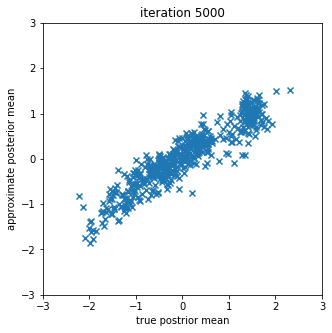

Epoch [5/10], Loss: 34.2331, Perplexity: 736591893619133.50

epoch 6 iteration 5000 loss 32.549 CE 31.982 KL 0.568 weighted KL: 0.567 weight 0.998
epoch 6 iteration 5100 loss 29.447 CE 28.803 KL 0.646 weighted KL: 0.645 weight 0.998
epoch 6 iteration 5200 loss 33.263 CE 32.603 KL 0.661 weighted KL: 0.660 weight 0.999
epoch 6 iteration 5300 loss 31.161 CE 30.481 KL 0.681 weighted KL: 0.681 weight 0.999
epoch 6 iteration 5400 loss 31.956 CE 31.369 KL 0.588 weighted KL: 0.587 weight 0.999
epoch 6 iteration 5500 loss 33.745 CE 33.162 KL 0.583 weighted KL: 0.583 weight 0.999
epoch 6 iteration 5600 loss 29.322 CE 28.800 KL 0.522 weighted KL: 0.522 weight 1.000
epoch 6 iteration 5700 loss 29.625 CE 28.873 KL 0.752 weighted KL: 0.752 weight 1.000
epoch 6 iteration 5800 loss 31.236 CE 30.631 KL 0.605 weighted KL: 0.605 weight 1.000
epoch 6 iteration 5900 loss 30.162 CE 29.176 KL 0.986 weighted KL: 0.986 weight 1.000


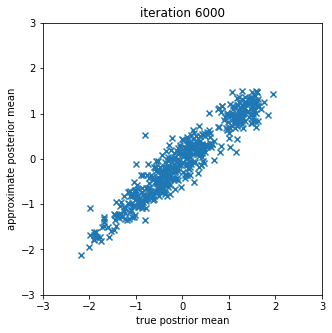

Epoch [6/10], Loss: 30.9817, Perplexity: 28522659877223.42

epoch 7 iteration 6000 loss 31.653 CE 31.144 KL 0.510 weighted KL: 0.510 weight 1.000
epoch 7 iteration 6100 loss 30.169 CE 29.430 KL 0.739 weighted KL: 0.739 weight 1.000
epoch 7 iteration 6200 loss 33.948 CE 33.344 KL 0.604 weighted KL: 0.603 weight 1.000
epoch 7 iteration 6300 loss 31.400 CE 30.766 KL 0.633 weighted KL: 0.633 weight 1.000
epoch 7 iteration 6400 loss 32.900 CE 32.134 KL 0.766 weighted KL: 0.766 weight 1.000
epoch 7 iteration 6500 loss 35.796 CE 35.243 KL 0.552 weighted KL: 0.552 weight 1.000
epoch 7 iteration 6600 loss 33.714 CE 33.177 KL 0.537 weighted KL: 0.537 weight 1.000
epoch 7 iteration 6700 loss 33.379 CE 32.859 KL 0.520 weighted KL: 0.520 weight 1.000
epoch 7 iteration 6800 loss 28.717 CE 27.950 KL 0.768 weighted KL: 0.768 weight 1.000
epoch 7 iteration 6900 loss 34.334 CE 33.691 KL 0.643 weighted KL: 0.643 weight 1.000


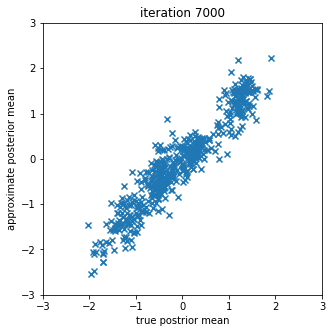

Epoch [7/10], Loss: 33.9461, Perplexity: 552827873805532.50

epoch 8 iteration 7000 loss 28.386 CE 27.577 KL 0.808 weighted KL: 0.808 weight 1.000
epoch 8 iteration 7100 loss 31.053 CE 30.412 KL 0.641 weighted KL: 0.641 weight 1.000
epoch 8 iteration 7200 loss 27.287 CE 26.562 KL 0.725 weighted KL: 0.725 weight 1.000
epoch 8 iteration 7300 loss 33.265 CE 32.705 KL 0.560 weighted KL: 0.560 weight 1.000
epoch 8 iteration 7400 loss 28.931 CE 28.113 KL 0.818 weighted KL: 0.818 weight 1.000
epoch 8 iteration 7500 loss 28.301 CE 27.383 KL 0.917 weighted KL: 0.917 weight 1.000
epoch 8 iteration 7600 loss 26.859 CE 26.056 KL 0.804 weighted KL: 0.804 weight 1.000
epoch 8 iteration 7700 loss 29.466 CE 28.591 KL 0.874 weighted KL: 0.874 weight 1.000
epoch 8 iteration 7800 loss 32.017 CE 31.398 KL 0.618 weighted KL: 0.618 weight 1.000
epoch 8 iteration 7900 loss 28.448 CE 28.001 KL 0.447 weighted KL: 0.447 weight 1.000


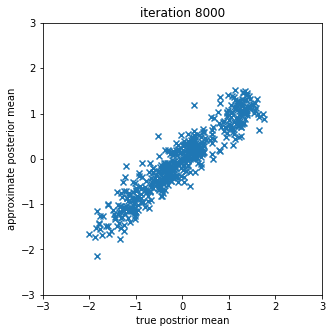

Epoch [8/10], Loss: 32.2602, Perplexity: 102431146218915.38

epoch 9 iteration 8000 loss 31.111 CE 30.679 KL 0.432 weighted KL: 0.432 weight 1.000
epoch 9 iteration 8100 loss 32.228 CE 31.466 KL 0.762 weighted KL: 0.762 weight 1.000
epoch 9 iteration 8200 loss 33.818 CE 33.274 KL 0.544 weighted KL: 0.544 weight 1.000
epoch 9 iteration 8300 loss 32.705 CE 32.075 KL 0.629 weighted KL: 0.629 weight 1.000
epoch 9 iteration 8400 loss 27.591 CE 26.883 KL 0.708 weighted KL: 0.708 weight 1.000
epoch 9 iteration 8500 loss 32.064 CE 31.625 KL 0.439 weighted KL: 0.439 weight 1.000
epoch 9 iteration 8600 loss 28.787 CE 27.824 KL 0.963 weighted KL: 0.963 weight 1.000
epoch 9 iteration 8700 loss 30.951 CE 30.418 KL 0.533 weighted KL: 0.533 weight 1.000
epoch 9 iteration 8800 loss 30.808 CE 30.208 KL 0.601 weighted KL: 0.601 weight 1.000
epoch 9 iteration 8900 loss 29.185 CE 28.759 KL 0.426 weighted KL: 0.426 weight 1.000


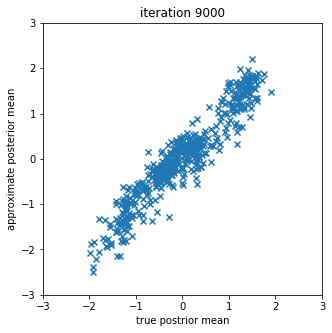

Epoch [9/10], Loss: 30.9179, Perplexity: 26760339745258.60

epoch 10 iteration 9000 loss 29.199 CE 28.713 KL 0.486 weighted KL: 0.486 weight 1.000
epoch 10 iteration 9100 loss 29.706 CE 29.170 KL 0.537 weighted KL: 0.537 weight 1.000
epoch 10 iteration 9200 loss 26.321 CE 25.697 KL 0.624 weighted KL: 0.624 weight 1.000
epoch 10 iteration 9300 loss 34.506 CE 34.062 KL 0.443 weighted KL: 0.443 weight 1.000
epoch 10 iteration 9400 loss 32.422 CE 31.887 KL 0.536 weighted KL: 0.536 weight 1.000
epoch 10 iteration 9500 loss 23.861 CE 23.130 KL 0.730 weighted KL: 0.730 weight 1.000
epoch 10 iteration 9600 loss 29.608 CE 28.848 KL 0.759 weighted KL: 0.759 weight 1.000
epoch 10 iteration 9700 loss 35.703 CE 35.225 KL 0.478 weighted KL: 0.478 weight 1.000
epoch 10 iteration 9800 loss 35.094 CE 34.574 KL 0.519 weighted KL: 0.519 weight 1.000
epoch 10 iteration 9900 loss 35.352 CE 34.926 KL 0.425 weighted KL: 0.425 weight 1.000


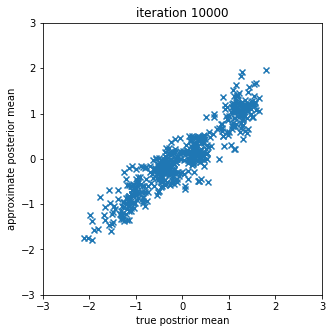

Epoch [10/10], Loss: 33.7577, Perplexity: 457901481449398.31



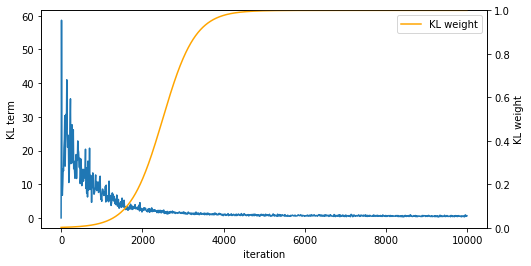

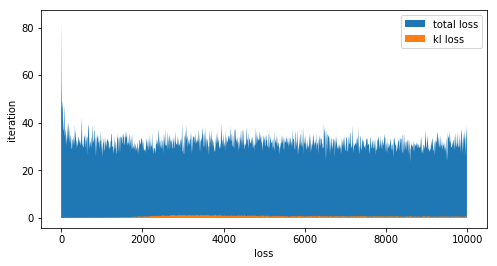

In [71]:
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=False)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, val_inputs, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

In [74]:
z1 = torch.randn([latent_size]).numpy()
z2 = torch.randn([latent_size]).numpy()
interpolation_points = generate_interpolation_sequence(z1, z2, number_of_sentences_to_decode=6)
# print(interpolation_points)

for z in interpolation_points:
    sentence = vae.generate(z, word2vec_model.wv.vocab['<sos>'].index, word2vec_model.wv.vocab['<eos>'].index, 10)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

### Create Word2Vec word embeddings

### Define RNNLM

In [25]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [42]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches_text(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 100

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

Epoch [1/100], Loss: 8.7546, Perplexity: 6339.97
Epoch [2/100], Loss: 7.1132, Perplexity: 1228.10
Epoch [3/100], Loss: 6.3702, Perplexity: 584.18
Epoch [4/100], Loss: 6.2321, Perplexity: 508.81
Epoch [5/100], Loss: 6.1860, Perplexity: 485.89
Epoch [6/100], Loss: 6.1471, Perplexity: 467.36
Epoch [7/100], Loss: 6.1089, Perplexity: 449.86
Epoch [8/100], Loss: 6.0653, Perplexity: 430.67
Epoch [9/100], Loss: 6.0204, Perplexity: 411.75
Epoch [10/100], Loss: 5.9771, Perplexity: 394.29
Epoch [11/100], Loss: 5.9356, Perplexity: 378.25
Epoch [12/100], Loss: 5.8952, Perplexity: 363.29
Epoch [13/100], Loss: 5.8557, Perplexity: 349.22
Epoch [14/100], Loss: 5.8168, Perplexity: 335.89
Epoch [15/100], Loss: 5.7792, Perplexity: 323.51
Epoch [16/100], Loss: 5.7420, Perplexity: 311.67
Epoch [17/100], Loss: 5.7056, Perplexity: 300.54
Epoch [18/100], Loss: 5.6702, Perplexity: 290.10
Epoch [19/100], Loss: 5.6339, Perplexity: 279.75
Epoch [20/100], Loss: 5.5994, Perplexity: 270.26
Epoch [21/100], Loss: 5.565

In [45]:
# Predict
test_sentences = ["in terms"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]

predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

NameError: name 'model' is not defined

### Beam search